# Preprocessing of Datasets

After installation a dataset needs some steps of preprocessing before being fed to down-stream pipelines. This tutorial shows how to do set up a pipeline of preprocessing for a built dataset. In general the pipeline consists of transformations at 3 consecutive levels:

1. File-level preprocessing: data selection, label modification, signal resampling & truncation etc.
2. Data-level preprocessing: feature extraction, windowed view, data augmentation etc.
3. Model-level preprocessing: modification to meet the specification of a machine learning model.

At the end of pipeline, the dataset will be transformed to some appropriate form for being used with ML models.

We use the dataset CWRU as example in this tutorial, but the same principle can be adapted to other datasets.

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds

import librosa
import librosa.display

import numpy as np
from matplotlib import pyplot as plt

from pathlib import Path

from IPython.display import Audio

import os

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # disable GPU devices
os.environ["TFDS_DATA_DIR"] = os.path.expanduser("~/tensorflow_datasets")  # default location of tfds database

2024-05-17 16:54:55.986318: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-17 16:54:56.694539: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:
import dpmhm

from dpmhm.datasets import transformer, preprocessing, feature, utils

## Load a built dataset

Suppose the dataset CWRU has been correctly installed, first we need to load the built dataset into memory. Note that the original dataset doesn't specify any split, and all data are contained in the field `train` of the built dataset.

In [5]:
dataset_name = 'CWRU'

ds_all, ds_info = tfds.load(
    dataset_name, 
    # data_dir='/home/han/Database/tensorflow_datasets/',
    # split=['train[:75%]', 'train[75%:]'],    
    with_info=True,
)

print(ds_all.keys())  # show the split of the raw dataset

ds0 = ds_all['train']

dict_keys(['train'])


2024-05-17 16:59:59.222424: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-05-17 16:59:59.222490: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:134] retrieving CUDA diagnostic information for host: Pluto
2024-05-17 16:59:59.222497: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:141] hostname: Pluto
2024-05-17 16:59:59.222577: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:165] libcuda reported version is: 550.78.0
2024-05-17 16:59:59.222593: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:169] kernel reported version is: 550.78.0
2024-05-17 16:59:59.222598: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:248] kernel version seems to match DSO: 550.78.0


The method `.element_spec()` shows the specification of data elements. Recall that a built dataset of `dpmhm` always contains the fields `{'signal', 'sampling_rate', 'metadata'}`.

In [6]:
ds0.element_spec

{'metadata': {'Dataset': TensorSpec(shape=(), dtype=tf.string, name=None),
  'FaultComponent': TensorSpec(shape=(), dtype=tf.string, name=None),
  'FaultLocation': TensorSpec(shape=(), dtype=tf.string, name=None),
  'FaultSize': TensorSpec(shape=(), dtype=tf.float32, name=None),
  'FileName': TensorSpec(shape=(), dtype=tf.string, name=None),
  'LoadForce': TensorSpec(shape=(), dtype=tf.uint32, name=None),
  'NominalRPM': TensorSpec(shape=(), dtype=tf.uint32, name=None),
  'RPM': TensorSpec(shape=(), dtype=tf.uint32, name=None)},
 'sampling_rate': TensorSpec(shape=(), dtype=tf.uint32, name=None),
 'signal': {'BA': TensorSpec(shape=(None,), dtype=tf.float32, name=None),
  'DE': TensorSpec(shape=(None,), dtype=tf.float32, name=None),
  'FE': TensorSpec(shape=(None,), dtype=tf.float32, name=None)}}

We note for CWRU that (not a general rule for other datasets of `dpmhm`)
- `metadata` has a subfiled `FaultLocation` taking values in {'DriveEnd', 'FanEnd', 'None'}, which is the main label of the record.
- The normal data can be equivalently identified by any of the following clauses: `FaultLocation==None`, `FaultComponent==None`, `FaultSize==0`.


Let's plot and play a sample from the dataset:

2024-05-17 17:00:45.758844: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


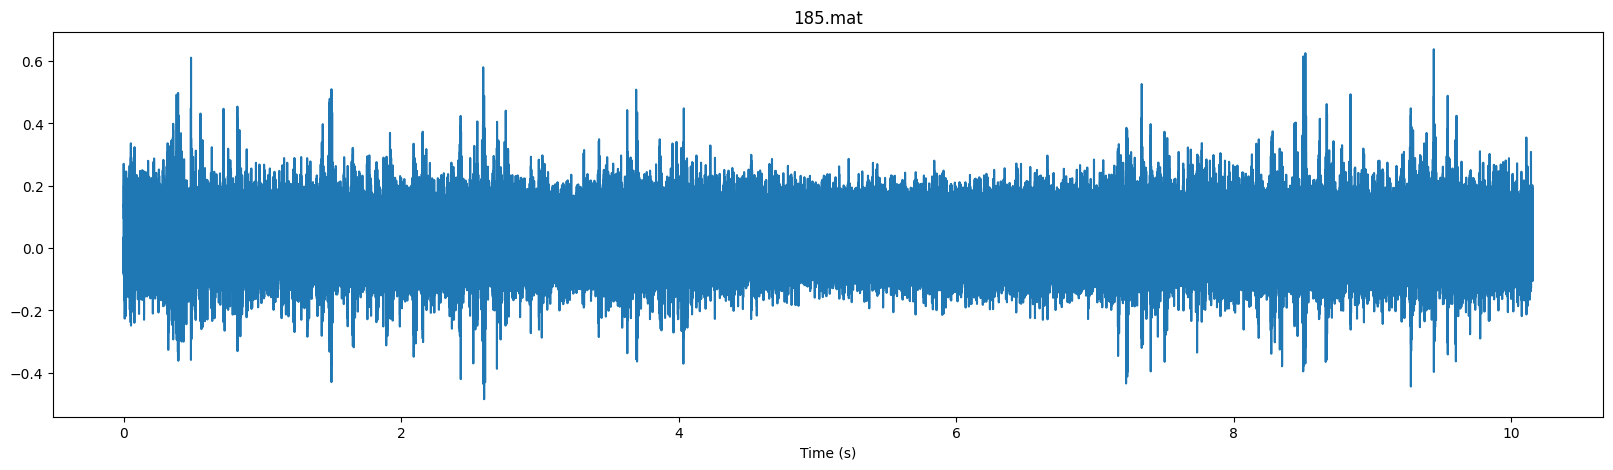

In [7]:
eles = list(ds0.take(10).as_numpy_iterator())

fn = eles[0]['metadata']['FileName'].decode()
sr = eles[0]['sampling_rate']
x = eles[0]['signal']['FE']

plt.figure(figsize=(20,5))
plt.plot(np.arange(len(x))/sr, x)
plt.xlabel('Time (s)')
plt.title(fn)

Audio(x, rate=sr)

## File-level preprocessing

These are preprocessings applied at the level of original records (or data files). 

#### Filter on the channels
CWRU contains 3 channels ['DE', 'FE', 'BA'], however some of them may be missing in some files (e.g. the file '148.mat' contains only channels 'DE' and 'FE', not 'BA'). Given the list of desired channels, e.g. ['DE', 'FE'], a first preprocessing step consists in selecting only the files in which all desired channels are simultaneously present. In this way the number of channels will be fixed. 

#### Ramification of labels
A dataset may come with some pre-defined labels, for example, the original labels of CWRU are ['None', 'DriveEnd', 'FanEnd'] (or the numeric value [0,1,2], contained in the field `metadata['FaultLocation']`), meaning that
- there is no fault
- the fault locates at the drive-end
- the fault locates at the fan-end

We may want to incorporate more information and make new labels at a finer level, for example by taking into account the subfield `FaultComponent` and `FaultSize` of the field `metadata`:
- `FaultComponent`: taking value in {'InnerRace', 'Ball', 'OuterRace3', 'OuterRace6', 'OuterRace12', 'None'}
- `FaultSize`: taking value in {0.007, 0.014, 0.021, 0.028, 0}

Together with the original label, the new label becomes a triplet `(FaultLocation, FaultComponent, FaultSize)`. For example, the triplet `(1, 'InnerRace', 0.007)` means the fault is located at the drive-end, on the inner-race component, and of size 0.007.

#### Resampling & sliding window view
The record in CWRU has variant duration (~ 10 or 2.5 seconds) and sampling rate (at 12000 or 48000 Hz), which may complicate the subsequent analysis. So we resample all signals at the fixed rate of 12000 Hz and trim them into windows of 1 second with hop size of 0.5 second.

#### Selection of domain 
We define the *domain* as the operating condition of a record. Note that in CWRU the field `LoadForce` (taking value in [0,1,2,3]) is one-to-one mapped to the nominal RPM `NominalRPM` (taking value in [797, 1772, 1750, 1730]), however this is not a general case for other datasets. We want to test if an algorithm of detection trained on one domain can work also on another despite the discrepancy between domains (called *domain-shift*).


Here is a template of variables for the file-level preprocessing.

In [8]:
# Filter on the channels
channels = ['DE', 'FE', 'BA']  # containing all channels
# channels = ['DE']  # containing only the channel 'DE'

# Label ramification
keys = ['FaultLocation', 'FaultComponent', 'FaultSize']  # finest label
# keys = []  # original label

# Selection of domain
# filters = {'LoadForce': [0,1,2]}  # source domain
filters = {}  # no selection

# Resampling rate in Hz
resampling_rate = 12000
# resampling_rate = None  # no resampling

# Size of the sliding window (after resampling)
window_size = resampling_rate  # 1 second

# Number of samples to skip between sucessive window
hop_size = window_size//2

### `DatasetCompactor` class

The class `dpmhm.datasets.transformer.DatasetCompactor` provides functionalities for the file-level preprocessing. Let's define the parameters of preprocessing and construct a compactor object. 

In [9]:
from dpmhm.datasets import transformer

compactor = transformer.DatasetCompactor(ds0, channels=channels, keys=keys, filters=filters,
                                         resampling_rate=resampling_rate, 
                                         window_size=window_size, hop_size=hop_size)

The new construction has the property `dataset` which is the transformed dataset. Let's compare the signature of the new dataset to the original one:

In [10]:
ds1 = compactor.dataset

print("Original:", ds0.element_spec['signal'])
print("Compacted:", ds1.element_spec['signal'])

Original: {'BA': TensorSpec(shape=(None,), dtype=tf.float32, name=None), 'DE': TensorSpec(shape=(None,), dtype=tf.float32, name=None), 'FE': TensorSpec(shape=(None,), dtype=tf.float32, name=None)}
Compacted: TensorSpec(shape=(3, None), dtype=tf.float32, name=None)


2024-05-17 17:07:45.057645: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


And take some elements from the new dataset:

In [12]:
eles1 = list(ds1.take(10).as_numpy_iterator())
eles0 = list(ds0.take(10).as_numpy_iterator())

2024-05-17 17:08:14.577997: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-05-17 17:08:14.686081: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


As expected, the new field 'signal' is now a 2D-array of fixed shape (3 channels and 12000 points):

In [13]:
for n, X in enumerate(eles1):
    print(n, f"label={X['label'].decode()}, shape={X['signal'].shape}")

0 label=f6ab3549af9ee45a, shape=(3, 12000)
1 label=f6ab3549af9ee45a, shape=(3, 12000)
2 label=f6ab3549af9ee45a, shape=(3, 12000)
3 label=f6ab3549af9ee45a, shape=(3, 12000)
4 label=f6ab3549af9ee45a, shape=(3, 12000)
5 label=f6ab3549af9ee45a, shape=(3, 12000)
6 label=f6ab3549af9ee45a, shape=(3, 12000)
7 label=f6ab3549af9ee45a, shape=(3, 12000)
8 label=f6ab3549af9ee45a, shape=(3, 12000)
9 label=f6ab3549af9ee45a, shape=(3, 12000)


The new label is an apparently random string. The property `compactor.full_label_dict` allows to find out the meaning of new labels. It can be seen that the label `dc8bcb86c369e78b` corresponds to the category `FaultLocation=2` (2 for 'FanEnd'), `FaultComponent='InnerRace'` and `FaultSize=0.021`. This property actually contains all possible labels that can be found in the dataset.

In [14]:
compactor.full_label_dict

2024-05-17 17:09:37.427300: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-05-17 17:09:37.687817: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-05-17 17:09:37.942839: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


{'f6ab3549af9ee45a': ['DriveEnd', 'Ball', '0.014'],
 '2533c59036dfe8c8': ['FanEnd', 'InnerRace', '0.007'],
 'b0a92d9d7379d8ce': ['DriveEnd', 'InnerRace', '0.007'],
 'dc8bcb86c369e78b': ['FanEnd', 'InnerRace', '0.021'],
 'd766ecd2592ce5ec': ['DriveEnd', 'Ball', '0.021'],
 '8af14bb8ad669337': ['FanEnd', 'OuterRace12', '0.007'],
 '55503c950ed81973': ['FanEnd', 'Ball', '0.014'],
 '8b9e80c02e1fca5b': ['FanEnd', 'OuterRace6', '0.007'],
 'd8957867a1fc0519': ['DriveEnd', 'OuterRace3', '0.007'],
 '5feef6a8996ff730': ['FanEnd', 'OuterRace6', '0.014'],
 '9c54396620a4b6a3': ['DriveEnd', 'OuterRace6', '0.021'],
 '6c2ba36f712d55e4': ['DriveEnd', 'OuterRace6', '0.014'],
 'd6de9a13f405da29': ['FanEnd', 'Ball', '0.007'],
 'e27e22f1f5037a20': ['DriveEnd', 'InnerRace', '0.014'],
 'a760eef52ceaa6f9': ['FanEnd', 'OuterRace3', '0.021'],
 '44bf66c5d8cd30e6': ['DriveEnd', 'OuterRace12', '0.021'],
 'd45bbeb3b8a72222': ['DriveEnd', 'OuterRace6', '0.007'],
 '35929ddfb4abb54d': ['DriveEnd', 'OuterRace12', '0.007'

We notice also that the several first elements in the new dataset all have the same `metadata`: this is of cause due to the sliding window view on the same data file.

In [15]:
for X in eles1:
    print(X['metadata'])

{'Dataset': b'CWRU', 'FaultComponent': b'Ball', 'FaultLocation': b'DriveEnd', 'FaultSize': 0.014, 'FileName': b'185.mat', 'LoadForce': 0, 'NominalRPM': 1797, 'RPM': 1796}
{'Dataset': b'CWRU', 'FaultComponent': b'Ball', 'FaultLocation': b'DriveEnd', 'FaultSize': 0.014, 'FileName': b'185.mat', 'LoadForce': 0, 'NominalRPM': 1797, 'RPM': 1796}
{'Dataset': b'CWRU', 'FaultComponent': b'Ball', 'FaultLocation': b'DriveEnd', 'FaultSize': 0.014, 'FileName': b'185.mat', 'LoadForce': 0, 'NominalRPM': 1797, 'RPM': 1796}
{'Dataset': b'CWRU', 'FaultComponent': b'Ball', 'FaultLocation': b'DriveEnd', 'FaultSize': 0.014, 'FileName': b'185.mat', 'LoadForce': 0, 'NominalRPM': 1797, 'RPM': 1796}
{'Dataset': b'CWRU', 'FaultComponent': b'Ball', 'FaultLocation': b'DriveEnd', 'FaultSize': 0.014, 'FileName': b'185.mat', 'LoadForce': 0, 'NominalRPM': 1797, 'RPM': 1796}
{'Dataset': b'CWRU', 'FaultComponent': b'Ball', 'FaultLocation': b'DriveEnd', 'FaultSize': 0.014, 'FileName': b'185.mat', 'LoadForce': 0, 'Nomina

As expected the first two records of the new dataset has a common part (plot in red) of length `hop_size`:

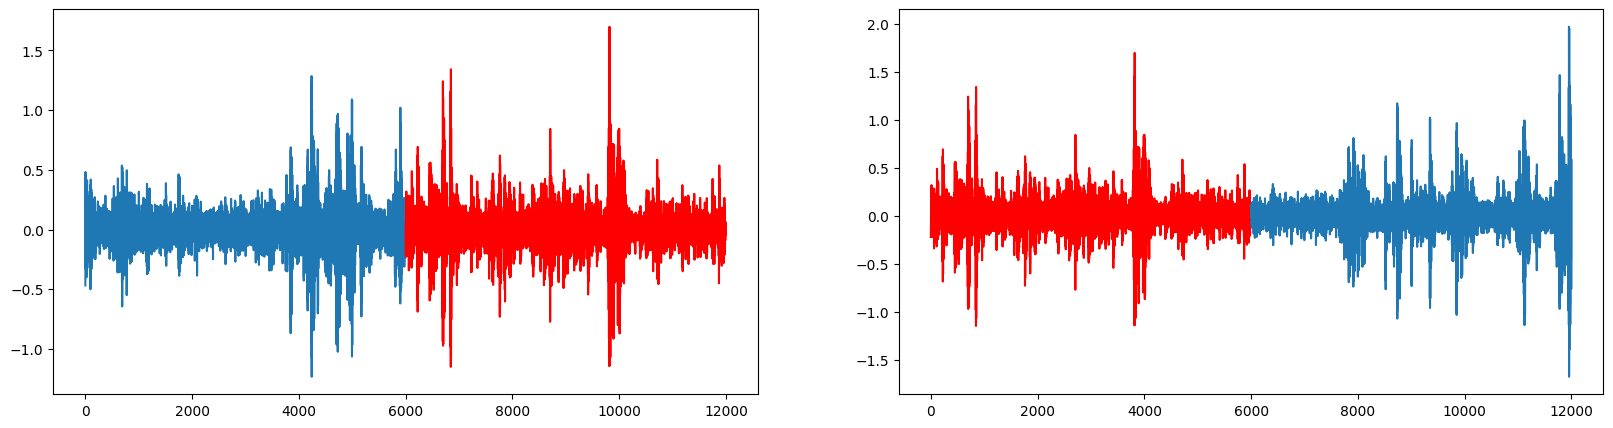

In [16]:
x0, x1 = eles1[0]['signal'][0], eles1[1]['signal'][0]

fig, axes = plt.subplots(1,2, figsize=(20,5))
axes[0].plot(np.arange(len(x0)//2), x0[:len(x0)//2])
axes[0].plot(np.arange(len(x0)//2, len(x0)), x0[len(x0)//2:], 'r')

axes[1].plot(np.arange(len(x1)//2), x1[:len(x1)//2], 'r')
axes[1].plot(np.arange(len(x1)//2, len(x1)), x1[len(x1)//2:])

# axes[1].plot(x1); axes[1].plot(x1[:len(x1)//2], 'b')

assert np.allclose(x0[hop_size:], x1[:hop_size])

## Data-level preprocessing

Data-level preprocessing aims at transforming the original waveform data to more advanced representation (e.g. spectrogram), and are applied after file-level preprocessings. Hereafter are some examples of data-level preprocessing.

#### Waveform augmentation
Currently not supported by `dpmhm`, see:

https://github.com/facebookresearch/WavAugment

#### Feature extraction
The following feature trasnformations are commonly used:
- Time-Frequency representation: spectrogram, MFCC etc.
- Cyclostationary representation
- Time-Scale representation: scalogram, EMD etc.

The output is a 2D representation of the original waveform. Implemented by `FeatureExtractor` class.

#### Sliding window view
Take a sliding window view on the 2D feature representation. The window has a fixed shape and moves at regular step in the 2D representation. Implemented by `WindowSlider` class.

#### Spectrogram augmentation
Perform random agumentations on a 2D feature representation. As the sliding window view, the output is also a 2D patch of fixed dimension. Implemented by `SpecAugment` class.


In the next we show how to apply data-level preprocessing. We start by some file-level preprocessing, including channel selection, label ramification and resampling:

In [17]:
# File-level parameters
channels = ['DE', 'FE', 'BA']

keys = ['FaultLocation', 'FaultComponent', 'FaultSize']  # finest label

compactor = transformer.DatasetCompactor(ds0, channels=channels, keys=keys, resampling_rate=12000)

### `FeatureExtractor` class

This class allows to transform the original 1d waveform to some 2d representation. It takes as input the preprocessed dataset at file-level and a callable of feature extractor,  e.g. spec or mfcc.

In [18]:
from dpmhm.datasets import feature

# Feature extractor
_func = lambda x, sr: feature.spectral_features(x, sr, 'spectrogram', 
                                                time_window=0.025, hop_step=0.0125, normalize=False,
                                                to_db=True)[0]

# _func = lambda x, sr: feature.spectral_features(x, sr, 'melspectrogram', 
#                                                 time_window=0.025, hop_step=0.0125, normalize=False,
#                                                 feature_kwargs={'n_mels':128})[0]

extractor = transformer.FeatureExtractor(compactor.dataset, _func)

The feature-transformed dataset is again contained in the property `.dataset`. Let's take some elements from it.

In [19]:
ds2 = extractor.dataset

eles2 = list(ds2.take(10).as_numpy_iterator())

2024-05-17 17:16:16.623891: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


The feature transformed dataset shares the same `label` and `metadata` of the compacted dataset:

In [20]:
ds1 = compactor.dataset
eles1 = list(ds1.take(10).as_numpy_iterator())

assert eles2[0]['metadata'] == eles1[0]['metadata']

assert eles2[0]['label'] == eles1[0]['label']

2024-05-17 17:16:27.773678: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


But the field `signal` is now replaced by `feature` which is the spectrogram of the original signal. It is a fixed-size 3D array with axes `(channel, frequency, time)`.

In [21]:
eles2[2]['feature'].shape

(3, 257, 815)

Let's show a sample from the feature transformed dataset.

Text(0, 0.5, 'Frequency bin')

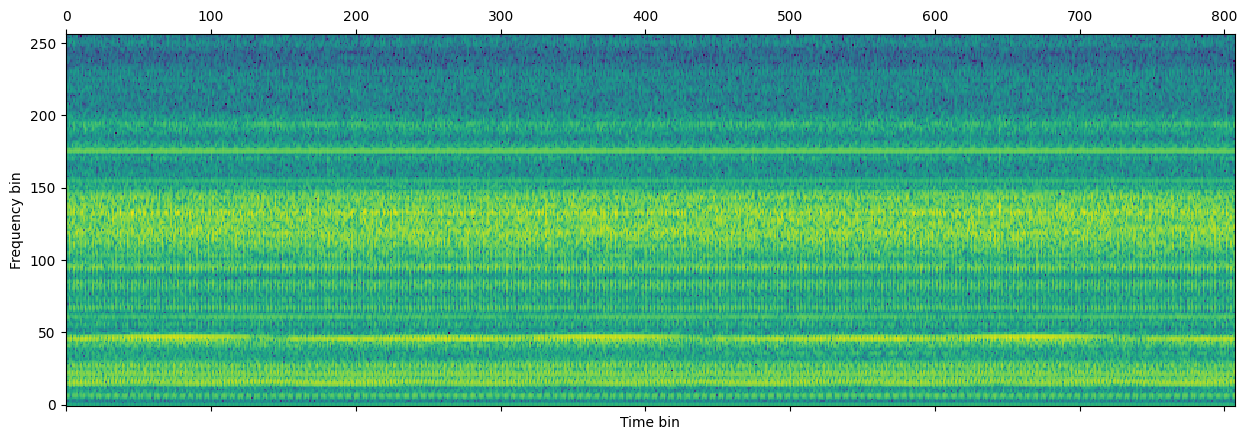

In [22]:
X = eles2[9]
plt.matshow(X['feature'][0], origin='lower')
plt.xlabel('Time bin')
plt.ylabel('Frequency bin')

### `WindowSlider` class

This class allows to get a sliding window view of a 2D representation. It takes as input the dataset of some feature extractor and apply a rectangle window with regular step. The output is the data on the window hence has  fixed dimension.

In [23]:
window = transformer.WindowSlider(extractor.dataset, window_size=(64,64), hop_size=(32,32))

ds3 = window.dataset

eles3 = list(ds3.take(10).as_numpy_iterator())

2024-05-17 17:18:13.438962: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-05-17 17:18:13.791787: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Text(0, 0.5, 'Frequency bin')

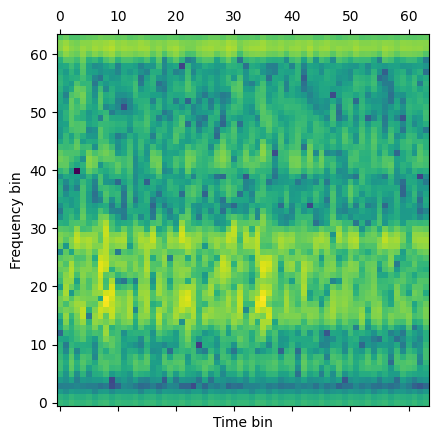

In [24]:
X = eles3[9]
plt.matshow(X['feature'][0], origin='lower')
plt.xlabel('Time bin')
plt.ylabel('Frequency bin')

### `SpecAugment` class

This class performs random augmentations on a feature dataset:

1. crop a random rectangle patch of the spectrogram
2. randomly flip the time axis
3. randomly blur the spectrogram
4. randomly fade along the time axis
     
After the step 1, the other steps are applied in order and independently with some probability. Note that the random patch in step 1 actually consists in resizing a random rectangle area satisfying some prescribed area & aspect constraints to a desired shape, therefore is different from the sliding window view of `WindowSlider` class which is just a simple view (without resizing).

In [25]:
specaug = transformer.SpecAugment(extractor.dataset, output_shape=(64, 64))

ds4 = specaug.dataset

eles4 = list(ds4.take(20).as_numpy_iterator())

2024-05-17 17:21:03.285028: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Text(0, 0.5, 'Frequency bin')

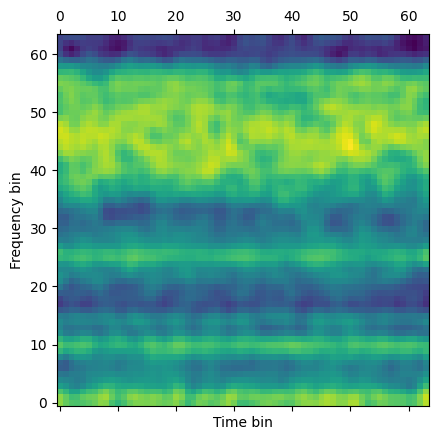

In [26]:
X = eles4[1]
plt.matshow(X['feature'][0], origin='lower')
plt.xlabel('Time bin')
plt.ylabel('Frequency bin')

Let's single out the random crop in step 1. The following code shows its actions under the hood. The output is the resize of a random rectangle area (in red) to a desired shape.

(31, 84) (574, 55)


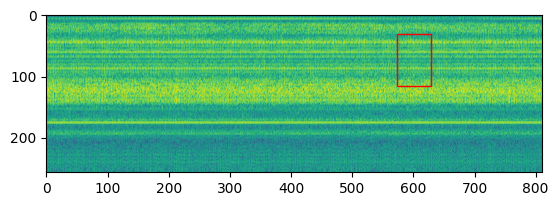

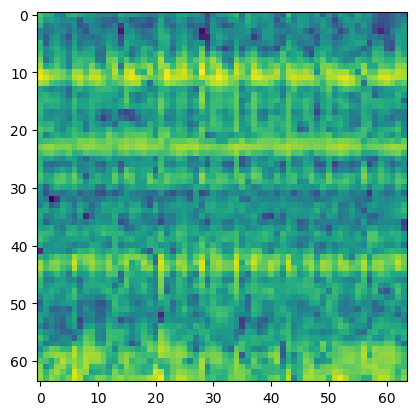

In [27]:
X = eles2[1]['feature']

import matplotlib.patches as patches

Y, hh, ww = dpmhm.datasets.augment.random_crop(X, (64,64), area_ratio=(0.01,1.), aspect_ratio=(1/2,2), channel_axis=0)
print(hh, ww)

plt.figure(); ax=plt.gca()
ax.imshow(X[0])
rect = patches.Rectangle((ww[0], hh[0]), ww[1], hh[1], linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(rect)

plt.figure()
plt.imshow(Y[0])

## Model-level preprocessing

After the data-level preprocessing, the original data are transformed into appropriate format and dimension and can be used for training ML models. The model-level preprocessing is the ultimate adaptation of data to the specification of a ML model, and may include 
- conversion of label: from string to integer
- conversion of channel: from the format of channel first to channel last
- creation of paired view
- load data by mini-batches & normalization
- ...


More about model-level preprocessing can be found in notebooks of ML topics.